# The California Housing Dataset

---

### Colab Note

Don't forget that you can link your notebook to your drive and save your work there. Then you can download and backup your models, reload them to keep training them, or upload datasets to your drive.

```python
import os
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/') # 'My Drive' is the default name of Google Drives
    os.listdir()
    
# use os.chdir("my-directory") # to change directory, and
# os.listdir()                 # to list its contents
# os.getcwd()                  # to get the name of the current directory
# os.mkdir("my-new-dir")       # to create a new directory
# See: https://realpython.com/working-with-files-in-python/

# You can also use bash commands directly, preceded by a bang
# !ls
# However, the following will *not* change the Python directory
# the notebook points to (use os.chdir for that)!
# !cd my-directory
```

### For reproducible results

```python
tf.random.set_seed(42) # can be any number
```

In [1]:
import numpy as np

import keras
import tensorflow as tf
import matplotlib.pyplot as plt

## Fetch the Dataset

In [2]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data(version="small")
print(train_data.shape, test_data.shape)

743530/743530 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(480, 8) (120, 8)


In [3]:
print(test_targets.max())
print(test_targets.min())

500001.0
74100.0


### Normalization

Compute `mean` and `std` from `train_data`, and apply those to both `train_data` and `test_data`. Also, divide `train_targets` and `test_targets` by `100000` to work on a sensible range.

In [4]:
# compute the mean, subtract from `train_data`
# then the std, and divide `train_data` by it
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
# shift & rescale
x_train = (train_data - mean) / std

# create an `x_test from `test_data`  using `mean` and `std` computed above
x_test = (test_data - mean) / std

# create `y_train` and `y_test` by dividing
# `train_targets` and `test_targets` by 100_000

y_train = train_targets / 100000
y_test = test_targets / 100000

## Model building & callback

In [5]:
def build_model(
    layers=[64, 64],
    activation="relu",
    dropout_rate=0,
    regularizer=None,
    regularizer_rate=0.002,
    optimizer="rmsprop",
    clear=True
):
    """
    Model building function

    Args:
        layers (iterable): [units, activation]
        dropout_rate (0: deactivated)
        regularizer (None: deactivated): l1 or l2 regularizer for hidden layers
        regularizer_rate (default: 0.002): rate applied to the regularizer
        optimizer (string or tf.keras.optimizers object): optimizer to use
        clear (boolean): whether to call tf.keras.backend.clear_session() before creating a new model

    Returns:
        the compiled Keras model
    """
    if clear:
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((x_train.shape[1],)))
    for units in layers:
        model.add(
            tf.keras.layers.Dense(
                units, activation = activation,
                kernel_regularizer=regularizer if regularizer is None else regularizer(regularizer_rate)
            )
        )
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

##### Note

Can you make the function above more modular? You could modify it so that it accepts arguments changing the architecture of the network, and other hyperparameters.

In [6]:
def train(
    model, x_train, y_train, validation_data,
    num_epochs, batch_size, callbacks=None, verbose=0
):
    """
    Training function

    Args:
        model (compiled Keras model)
        x_train (np.array or tf tensor): the training data
        y_train (np.array or tf tensor): the training targets
        validation_data (iterable): tuple/list containing validation data and targets (both either np.array or tf tensor)
        num_epochs (int): the number of epochs to train for
        batch_size (int): the batch size
        callbacks (iterable): a list/tuple containing Keras callbacks
        verbose (int): verbosity levels for model.fit()

    Returns:
        the history object returned by model.fit()
    """
    if validation_data is not None:
        x_val, y_val = validation_data
    # Train the model (in silent mode, verbose=0)
    return model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val) if validation_data else None,
        epochs=num_epochs, batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
    )

#### Custom Callback

In [7]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

## The K-fold algorithm

In [8]:
K = 4
num_val_samples = len(x_train) // K
num_epochs = 100
all_mae_histories = []
for i in range(K):
    print('processing fold', i)

    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = x_train[a : b]
    val_targets = y_train[a : b]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate([x_train[:a], x_train[b:]], axis=0)
    partial_y_train = np.concatenate([y_train[:a], y_train[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()

    # Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_x_train,
        partial_y_train,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0,
        callbacks=[CustomCallback(num_epochs)]
    )

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
\ epoch: 100/100
processing fold 1
\ epoch: 100/100
processing fold 2
\ epoch: 100/100
processing fold 3
\ epoch: 100/100


### Visualise your results

Can you think of a way to automate the visualisation once the training is done? This would mean encapsulating the plotting code into a function, and calling it once the K-fold loop is done.

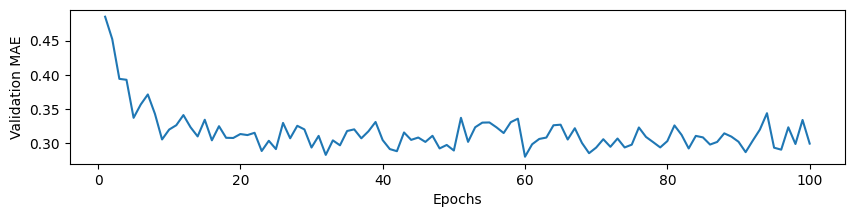

In [9]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)
plt.figure(figsize=(10,2))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [10]:
def smooth_curve(points, beta = 0.9):       # beta must be between 0 and 1!
    smoothed_points = []
    for current in points:
        if smoothed_points:                 # (an nonempty list is 'True')
            previous = smoothed_points[-1]  # the last appended point
                                            # ↓ a weighted sum of previous & point, controlled by beta
            smoothed_points.append(beta * previous + (1 - beta) * current)
        else:
            smoothed_points.append(current) # at the start, the list is empty, we just add the first point
    return smoothed_points

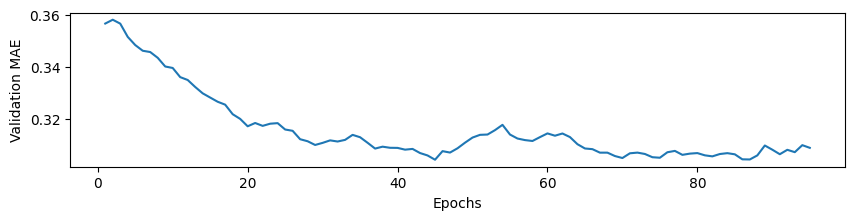

In [11]:
smooth_mae_history = smooth_curve(average_mae_history[5:])
plt.figure(figsize=(10,2))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Experiments

- Run k-fold validation on the California dataset;
- Notice that the mini-batch size is set to 1. Experiment with different mini-batch sizes. What do you observe? Can you account for your observation?
- Run a series of experiments to find the best model, like in previous labs.

The obvious thing to be done here is to compare the results between the small random subset and the full dataset, if you were to train models on it (don't forget to split into train, validation and test sets when you work on the full data!). Varying the size of the test set could also be of interest.

### Experiment 1

- Test various batch sizes

First of all, here are two examples of functions plotting the validation MAE and the smoothed version.

The following uses two subplots, aligning the `x` axis.

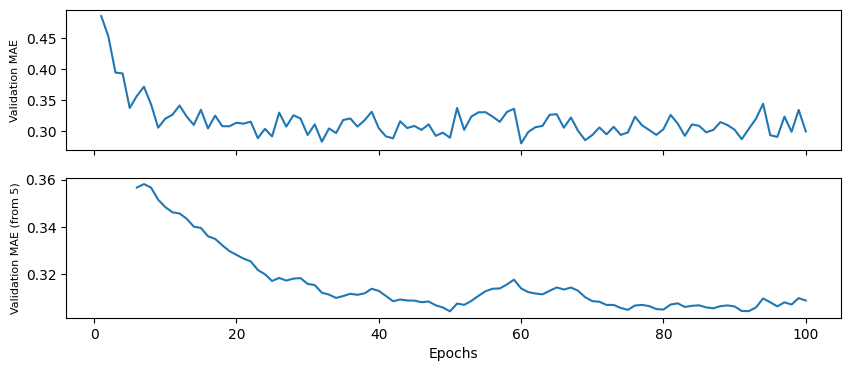

In [12]:
def subplots_avg_and_smooth(average_mae_history, omit=5):

    fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)

    # plot the raw history
    axs[0].plot(range(1, len(average_mae_history) + 1), average_mae_history)
    axs[0].set_ylabel('Validation MAE', fontsize=8)

    # create the EMA data and plot it
    smooth_mae_history = smooth_curve(average_mae_history[omit:])
    axs[1].plot(range(omit + 1, len(smooth_mae_history) + omit + 1), smooth_mae_history)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel(f"Validation MAE (from {omit})", fontsize=8)

    plt.show()

subplots_avg_and_smooth(average_mae_history)

The second one plots the exponential moving average (EMA) of our MAE values on top of the raw ones.

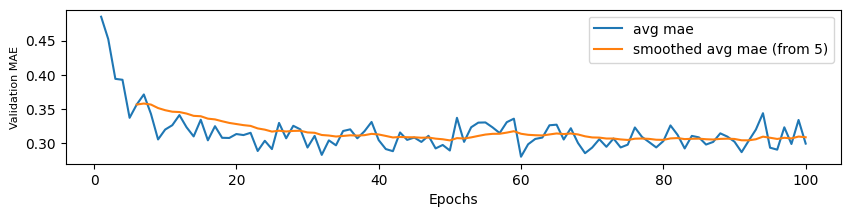

In [13]:
def plot_avg_and_smooth(average_mae_history, omit=5):

    smooth_mae_history = smooth_curve(average_mae_history[omit:])

    plt.figure(figsize=(10,2))
    plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, label="avg mae")
    plt.plot(range(omit + 1, len(smooth_mae_history) + omit + 1), smooth_mae_history, label=f"smoothed avg mae (from {omit})")
    plt.ylabel('Validation MAE', fontsize=8)
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_avg_and_smooth(average_mae_history)

I will now gather the code required for the K-Fold algorithm into a function, for ease of use.

A slightly modified callback that knows which fold we are in.

In [14]:
class FoldCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, fold):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
        self.fold = fold
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\']
        print(f"\r        {c[epoch % 4]} fold: {self.fold + 1} | epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

The K-fold validation function.

In [15]:
def run_kfold(
    x_train, y_train, model_params,
    batch_size, K=4, num_epochs=100,
    clear=True
):
    """
    Run the K-Fold algorithm

    Args:
        x_train (np.array or tf tensor): the training data
        y_train (np.array or tf tensor): the training targets
        model_params (dict): a dictionary containing parameters (used to configure the model in
             various runs, and to retrieve the best params later), structured like so:
            {
                "layers":           [units_1, units_2, ..., units_3], # units per layer, determines the number of layers
                "activation":       "relu", # which activation to use at each layer
                "dropout_rate":     0,      # the dropout rate (0: no dropout)
                "regularizer_rate": 0,      # the regularizer rate (not used if "regularizer" is None)
                "regularizer":      None    # the regularizer to use (pass a regularizer object, e.g. `tf.keras.regularizers.l2`)
            }
        batch_size (int): the batch size
        K (int): the number of folds
        num_epochs (int): the number of epochs per training run
        clear (bool): whether to call tf.keras.backend.clear_session() before the runs

    Returns:
        all_mae_histories (list, validation mae values for K runs)
    """
    if clear:
        tf.keras.backend.clear_session()

    num_val_samples = len(x_train) // K
    all_mae_histories = []

    for i in range(K):

        # Prepare the validation data: data from partition i
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data = x_train[a : b]
        val_targets = y_train[a : b]

        # Prepare the training data: data from all other partitions
        partial_x_train = np.concatenate([x_train[:a], x_train[b:]], axis=0)
        partial_y_train = np.concatenate([y_train[:a], y_train[b:]], axis=0)

        # Build the Keras model (already compiled)
        model = build_model(**model_params) # https://realpython.com/python-kwargs-and-args/

        # Train the model
        history = train(
            model,
            partial_x_train,
            partial_y_train,
            validation_data=(val_data, val_targets),
            num_epochs=num_epochs, batch_size=batch_size,
            callbacks=[FoldCallback(num_epochs, i)]
        )

        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)
        del model # save memory

    return all_mae_histories

I will use the same model parameters as in the initial example. I also implement a helper function to print the parameters easily.

In [16]:
model_params = {
    "layers":           [64, 64],
    "activation":       "relu",
    "dropout_rate":     0,
    "regularizer_rate": 0,
    "regularizer":      None
}

# https://realpython.com/python-kwargs-and-args/
def print_params(params, **kwargs):
    print(f"Model params:")
    # print params
    for k,v in params.items():
        print(f" - {k}: {v}")
    # print additional keyword arguments
    for k,v in kwargs.items():
        print(f" - {k}: {v}")
    print("-" * 30)

print_params(model_params)

Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0
 - regularizer_rate: 0
 - regularizer: None
------------------------------


Training four models with four different batch sizes.

Additionally, it is useful to have a helper function to retrieve the epoch and lowest value from a list of value.

In [17]:
def retrieve_lowest_mae(hist):
    epoch = np.argmin(hist)
    best_mae = hist[epoch]
    return epoch, best_mae

We are now ready to train models on various batch sizes.

Testing various batch sizes
---------------------------
Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0
 - regularizer_rate: 0
 - regularizer: None
------------------------------
 - batch size: 1

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


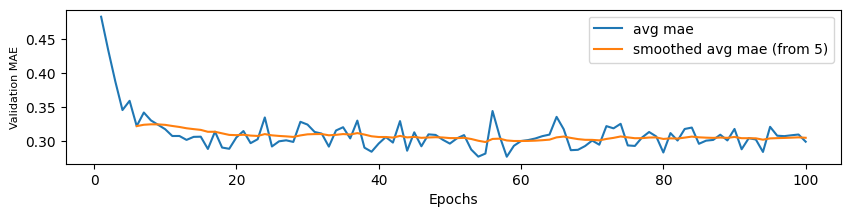

      Lowest MAE: 0.2771349959075451 at epoch 58
      --------------------------------------------------------------------------------

 - batch size: 16

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


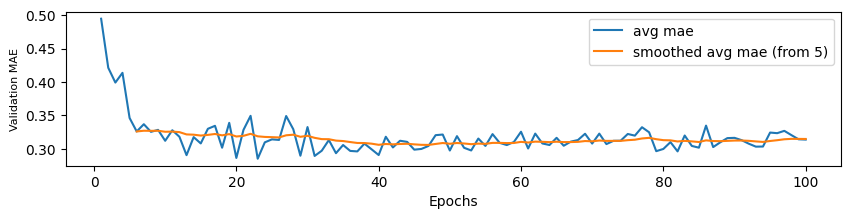

      Lowest MAE: 0.28504689782857895 at epoch 23
      --------------------------------------------------------------------------------

 - batch size: 64

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


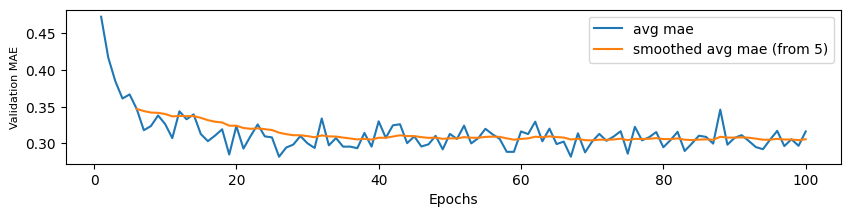

      Lowest MAE: 0.28180063888430595 at epoch 26
      --------------------------------------------------------------------------------

 - batch size: 256

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


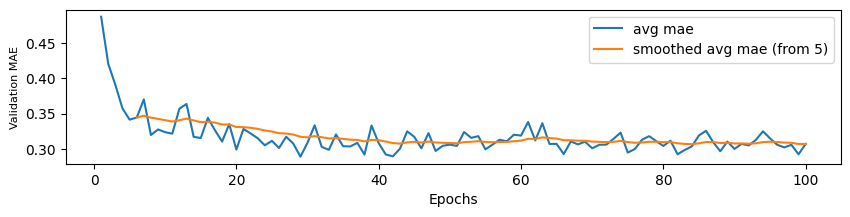

      Lowest MAE: 0.28905829042196274 at epoch 29
      --------------------------------------------------------------------------------

 - batch size: 512

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


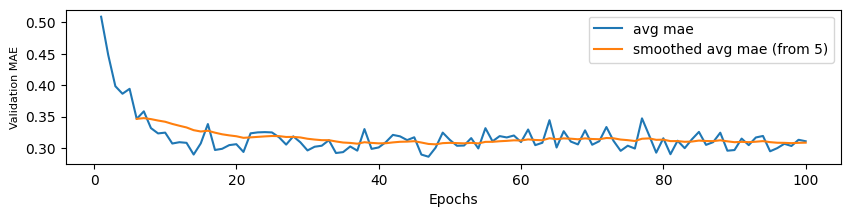

      Lowest MAE: 0.2863451912999153 at epoch 47
      --------------------------------------------------------------------------------

Results:
 - batch size: 256 | lowest val mae: 0.28906 at epoch: 28
 - batch size: 512 | lowest val mae: 0.28635 at epoch: 46
 - batch size:  16 | lowest val mae: 0.28505 at epoch: 22
 - batch size:  64 | lowest val mae: 0.28180 at epoch: 25
 - batch size:   1 | lowest val mae: 0.27713 at epoch: 57

The best MAE result, 0.2771349959075451 (epoch 57), was achieved with batch size 1.


In [18]:
import gc # we will need to clear the memory to prevent the Colab session to crash

num_epochs = 100
batch_sizes = [1, 16, 64, 256, 512]

msg = "Testing various batch sizes"
print(msg)
print("-"*len(msg))
print_params(model_params)

all_epochs = []
all_maes = []
for b in batch_sizes:

    print(f" - batch size: {b}")
    print()

    # run k-fold
    mae_histories = run_kfold(
        x_train, y_train, model_params,
        batch_size=1, K=4, num_epochs=num_epochs
    )

    # compute the mean
    avg_mae_history = np.array(mae_histories).mean(axis=0)

    # plot
    plot_avg_and_smooth(avg_mae_history)

    # retrieve & save results
    best_mae_epoch, best_mae = retrieve_lowest_mae(avg_mae_history)
    all_epochs.append(best_mae_epoch)
    all_maes.append(best_mae)

    # print best mae
    print(f"      Lowest MAE: {best_mae} at epoch {best_mae_epoch+1}")
    print("      " + "-" * 80)
    print()

    gc.collect() # save memory

# sort all our results
indz = np.argsort(np.array(all_maes))
sorted_epochs = np.array(all_epochs)[indz][::-1] # reverse sort
sorted_maes = np.array(all_maes)[indz][::-1]
sorted_batch_sizes = np.array(batch_sizes)[indz][::-1]

# string formatting
longest_bs = len(str(max(batch_sizes)))
longest_ep = len(str(max(all_epochs)))

# print our final results
print("=" * 80)
print("Results:")
for bs, mae, ep in zip(sorted_batch_sizes, sorted_maes, sorted_epochs):
    print(f" - batch size: {bs:>{longest_bs}} | lowest val mae: {mae:>.5f} at epoch: {ep:>{longest_ep}}")

print()
print(f"The best MAE result, {sorted_maes[-1]} (epoch {sorted_epochs[-1]}), was achieved with batch size {sorted_batch_sizes[-1]}.")

The best value is obtained with batch size `1`, at epoch `57`. In the runs performed, increasing the batch size did not seem to have had a positive effect on our final results, however the epoch at which the best values were found vary significantly (second-best result wiht batch `65` after only `25` epochs). It might be interesting to see if this result is robust, by running experiments with more batch sizes, and seeing if consistent results. This would also help establishing what part the randomness in our system plays in this particular result.

### Experiments 2

- Testing random search with *iterated K-fold validation with shuffling*

Using the tools we developed above, we can now proceed to expand our experiments to tune other hyperparameters as well. Even if this isn't as common as grid search, **random search**, where we randomly select has some hyperparameters, and set up the number of runs we wish to perform according to our compute and time constraints, has some proponents, such as Andrej Karpathy. He summarizes the argument in favour of random search in the following way: "Intuitively, this is because neural nets are often much more sensitive to some parameters than others. In the limit, if a parameter a matters but changing b has no effect then you’d rather sample a more throughly than at a few fixed points multiple times."  
Source: ["A Recipe for Training Neural Networks", 5. Tune, Apr 25, 2019](https://karpathy.github.io/2019/04/25/recipe/#5-tune)

Here is an additional plotting helper, this time to plot multiple MAE histories (with some transparency) as well as the average of those.

In [19]:
def plot_multiple_histories(histories, avg, label="fold:", omit=5, figsize=(8,2)):
    plt.figure(figsize=figsize)
    # quite subtle and frustrating business to make sure the epochs on the
    # plots show the same results as when printing (shifts by ones are the worst!)
    for i, hist in enumerate(histories):
        h = hist[omit:]
        plt.plot(range(omit + 1, len(h) + omit + 1), h, label=f"{label} {i+1}", alpha=.2)
    a = avg[omit:]
    plt.plot(range(omit + 1, len(a) + omit + 1), a, label=f"average", color='r')
    plt.xticks(range(omit + 1, len(a) + omit + 1), fontsize=6)
    plt.ylabel('Validation MAE', fontsize=8)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

We will need a utility to generate random hyperparameters. Here, each hyperparameter we wish to test is examined in advance, so that we have an idea of what values to expect, and then we use `NumPy` either to generate numbers, or to pick one element in an array for us.

In [20]:
def random_params():
    return {
        "layers":           [2**np.random.randint(3,8)] * np.random.randint(1,4), # [8] to [256,256,256]
        "activation":       np.random.choice(["relu", "tanh"]),
        "dropout_rate":     np.random.choice([0, .1, .3, .5]),  # this way 0 dropout sometimes happens
        "regularizer_rate": np.random.random() * .5,            # 0 - .5
        "regularizer":      np.random.choice(
                                [None, tf.keras.regularizers.l1, tf.keras.regularizers.l2]
                            ),
    }

print_params(random_params()) # generate and print

Model params:
 - layers: [8, 8, 8]
 - activation: tanh
 - dropout_rate: 0.1
 - regularizer_rate: 0.47891488585241077
 - regularizer: <class 'keras.src.regularizers.regularizers.L1'>
------------------------------


Now it is possible to write a function wrapping `run_kfold`, and feeding it a shuffled version of the dataset.

In [21]:
def iterated_kfold(
    x_train, y_train,
    model_params, batch_size,
    n_iter=5, K=4, num_epochs=100,
):

    """
    Run Iterated K-Fold with Shuffling

    Args:
        x_train (np.array or tf tensor): the training data
        y_train (np.array or tf tensor): the training targets
        model_params (dict): a dictionary containing parameters (used to configure the model in
             various runs, and to retrieve the best params later), structured like so:
            {
                "layers":           [units_1, units_2, ..., units_3], # units per layer, determines the number of layers
                "activation":       "relu", # which activation to use at each layer
                "dropout_rate":     0,      # the dropout rate (0: no dropout)
                "regularizer_rate": 0,      # the regularizer rate (not used if "regularizer" is None)
                "regularizer":      None    # the regularizer to use (pass a regularizer object, e.g. `tf.keras.regularizers.l2`)
            }
        batch_size (int): the batch size
        K (int): the number of folds for the K-fold algorithm
        n_iter (int): the number of iterations (how many shufflings & k-folds we perofrm)
        num_epochs (int): the number of epochs per training run

    Returns:
        best_overall_mae (float, best MAE value for all runs)
        best_overall_mae_epoch (int, epoch at which the best value was reached)
        iterated_avg_mae_history (list, average validation mae values for the best K-fold run)
    """

    assert x_train.shape[0] == y_train.shape[0], f"`x_train` ({x_train.shape[0]}) and `y_train` ({y_train.shape[0]}) must contain the same amount of elements!"

    all_iterated_mae_histories = []

    for i in range(n_iter):

        print()
        print(f"Iteration: {i+1}/{n_iter} | K-folding with k={K}")
        print()

        # shuffling indices
        shuffled_indz = np.random.permutation(x_train.shape[0])

        # using indices to shuffle data & targets
        shuffled_x_train = x_train[shuffled_indz]
        shuffled_y_train = y_train[shuffled_indz]

        # run k-fold on shuffled dataset
        mae_histories = run_kfold(
            shuffled_x_train, shuffled_y_train,
            model_params, batch_size,
            K=K, num_epochs=num_epochs,
        )

        # compute the mean and append to our histories
        avg_mae_history = np.array(mae_histories).mean(axis=0)
        all_iterated_mae_histories.append(avg_mae_history)

        # # plot each fold & average
        # plot_multiple_histories(mae_histories, avg_mae_history)

        best_mae_epoch, best_mae = retrieve_lowest_mae(avg_mae_history)
        print()
        print(f"      Lowest average MAE: {best_mae} at epoch {best_mae_epoch + 1}.")
        print("      " + "-" * 80)

        gc.collect() # save memory

    print()
    msg = f"Finished performing {n_iter} iterations, results:"
    print("=" * len(msg))
    print(msg)

    iterated_avg_mae_history = np.array(all_iterated_mae_histories).mean(axis=0)

    # plot
    plot_multiple_histories(
        all_iterated_mae_histories, iterated_avg_mae_history,
        label="iteration:", figsize=(17,3))

    best_overall_mae_epoch, best_overall_mae = retrieve_lowest_mae(iterated_avg_mae_history)

    print()
    print(f"After {n_iter} x {K} = {n_iter*K} runs, lowest MAE result: {best_overall_mae} at epoch {best_overall_mae_epoch + 1}.")
    print()
    print_params(model_params)

    return best_overall_mae, best_overall_mae_epoch, iterated_avg_mae_history

Here, we generate random parameters outside the call to `iterated_kfold`, and simply save the current parameters if the MAE result is lower than the currently saved best result. This cell is likely to take some time to run, especially if `n_trials` is large!

Here we run `5` trials (sets of hyperparameters), and each of those is tested on `2` iterations of the K-fold algorithm (with `K = 3`), each run training for `100` epochs, as a demonstration of how the system works, but given more time, one could certainly consider increasing these numbers, to see if it is possible to obtain an even lower MAE value.

Random Search through Iterated K-Fold with Shuffling
----------------------------------------------------

Trial: 1/5, generating random hyperparameters...

Model params:
 - layers: [32, 32]
 - activation: relu
 - dropout_rate: 0.1
 - regularizer_rate: 0.47504103798269504
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 1
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.3931800425052643 at epoch 59.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.38853692015012103 at epoch 81.
      --------------------------------------------------------------------------------

Finished performing 2 iterations, 

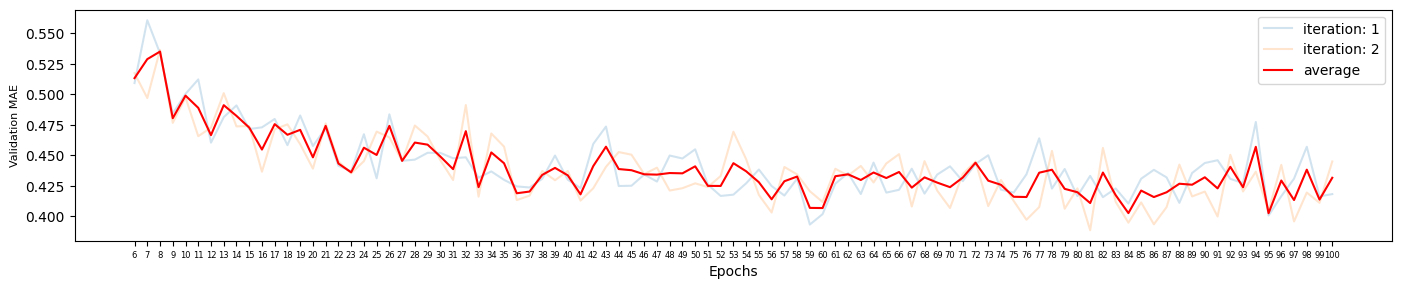


After 2 x 3 = 6 runs, lowest MAE result: 0.40248752633730567 at epoch 95.

Model params:
 - layers: [32, 32]
 - activation: relu
 - dropout_rate: 0.1
 - regularizer_rate: 0.47504103798269504
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 2/5, generating random hyperparameters...

Model params:
 - layers: [128]
 - activation: relu
 - dropout_rate: 0.3
 - regularizer_rate: 0.3749079783172689
 - regularizer: None
 - batch_size: 4
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.2860720654328664 at epoch 81.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        \ f

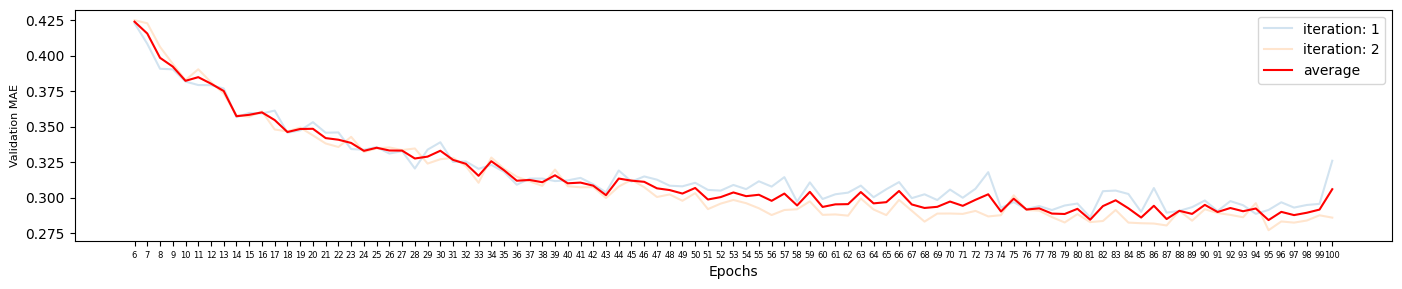


After 2 x 3 = 6 runs, lowest MAE result: 0.2841151158014933 at epoch 95.

Model params:
 - layers: [128]
 - activation: relu
 - dropout_rate: 0.3
 - regularizer_rate: 0.3749079783172689
 - regularizer: None
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 3/5, generating random hyperparameters...

Model params:
 - layers: [32, 32, 32]
 - activation: tanh
 - dropout_rate: 0.0
 - regularizer_rate: 0.1491912321497355
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 8
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.39001362522443134 at epoch 45.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        

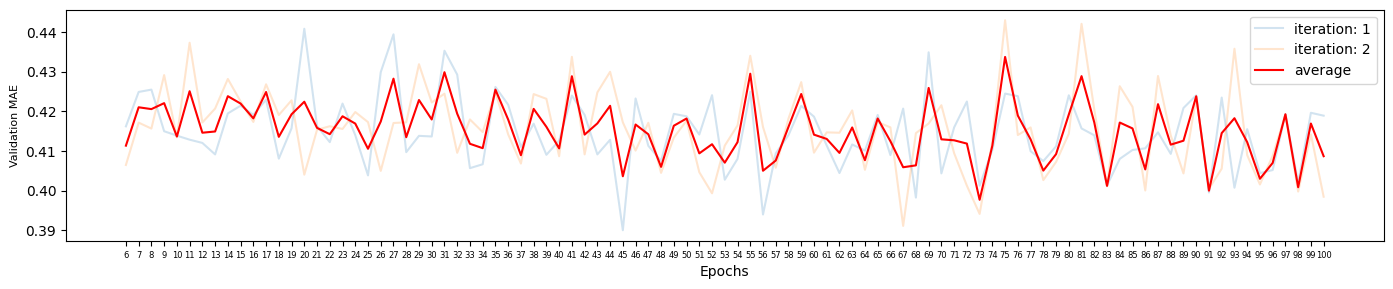


After 2 x 3 = 6 runs, lowest MAE result: 0.3976914038260778 at epoch 73.

Model params:
 - layers: [32, 32, 32]
 - activation: tanh
 - dropout_rate: 0.0
 - regularizer_rate: 0.1491912321497355
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 4/5, generating random hyperparameters...

Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0.1
 - regularizer_rate: 0.47742827062730453
 - regularizer: None
 - batch_size: 4
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.26137914260228473 at epoch 82.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

    

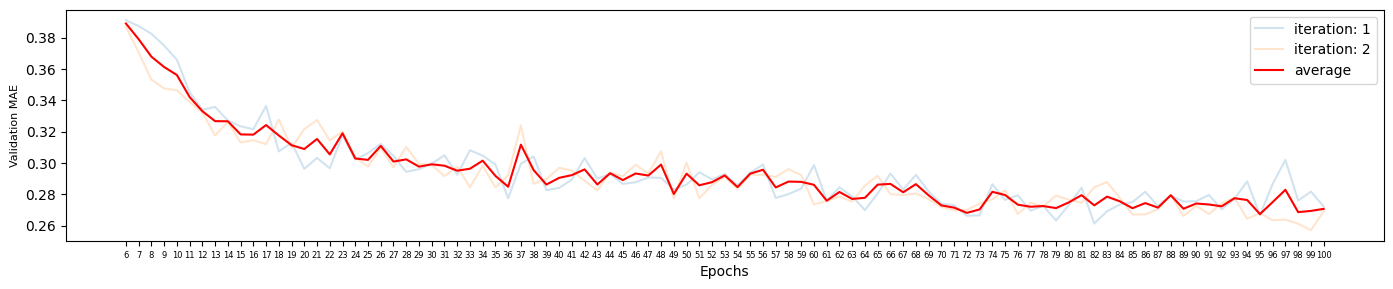


After 2 x 3 = 6 runs, lowest MAE result: 0.2673511207103729 at epoch 95.

Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0.1
 - regularizer_rate: 0.47742827062730453
 - regularizer: None
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 5/5, generating random hyperparameters...

Model params:
 - layers: [64]
 - activation: relu
 - dropout_rate: 0.0
 - regularizer_rate: 0.38121100625761106
 - regularizer: <class 'keras.src.regularizers.regularizers.L1'>
 - batch_size: 16
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 0.4458003242810567 at epoch 100.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        \ 

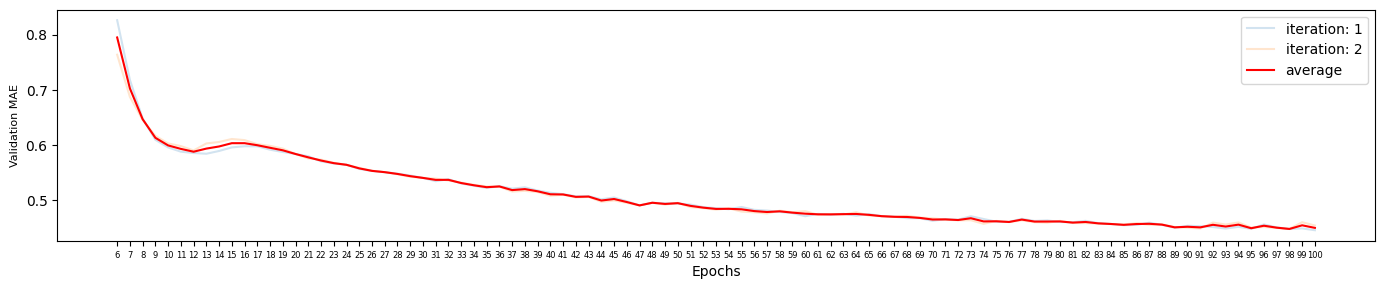


After 2 x 3 = 6 runs, lowest MAE result: 0.4481016447146734 at epoch 98.

Model params:
 - layers: [64]
 - activation: relu
 - dropout_rate: 0.0
 - regularizer_rate: 0.38121100625761106
 - regularizer: <class 'keras.src.regularizers.regularizers.L1'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------
Best result found: MAE: 0.2673511207103729 at epoch 95.
Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0.1
 - regularizer_rate: 0.47742827062730453
 - regularizer: None
 - batch_size: 4
------------------------------


In [22]:
best_results = {
    "mae": np.inf, # to start with
}

msg = "Random Search through Iterated K-Fold with Shuffling"
print(msg)
print("-"*len(msg))

n_trials = 5

# O nestedness! We try 10 different random parameters
for i in range(n_trials):

    # get random params
    model_params = random_params()
    # get random batch size
    batch_size = 2 ** np.random.randint(0,5)

    # print
    print()
    print(f"Trial: {i+1}/{n_trials}, generating random hyperparameters...")
    print()
    print_params(model_params, batch_size=batch_size)

    # run n_iter x k experiments
    best_mae, best_epoch, _ = iterated_kfold(
        x_train, y_train,
        model_params, batch_size,
        num_epochs=100,
        n_iter=2, K=3,
    )

    # update results
    if best_mae < best_results["mae"]:
        best_results = {
            "mae": best_mae,
            "epoch": best_epoch,
            "params": model_params,
            "batch_size": batch_size
        }

    print()
    print("-" * 140)

print(f"Best result found: MAE: {best_results['mae']} at epoch {best_results['epoch'] + 1}.")
print_params(best_results["params"], batch_size=best_results["batch_size"])

## 2. Conclusion

Retrain the best model:
 - with the same hyperparameters
 - on the entire the training data (`train_data` and `train_targets`)
 - without validation data
 - up until the best epoch (lowest average MAE)
 - and then evaluate on the test data (`test_data`, `test_targets`).

In [23]:
best_results

{'mae': np.float64(0.2673511207103729),
 'epoch': np.int64(94),
 'params': {'layers': [64, 64],
  'activation': np.str_('relu'),
  'dropout_rate': np.float64(0.1),
  'regularizer_rate': 0.47742827062730453,
  'regularizer': None},
 'batch_size': 4}

In [26]:
final_model = build_model(**best_results["params"])
_ = train(
    final_model,
    x_train,
    y_train,
    validation_data=None,
    num_epochs=best_results["epoch"],
    batch_size=best_results["batch_size"]
)

result = model.evaluate(x_test, y_test, verbose=0)
print("Final results:")
print(f"MSE: {result[0]}, MAE: {result[1]}")

Final results:
MSE: 0.3450683057308197, MAE: 0.33294448256492615


Our final result is an MAE of $3.33$ (approximately \$33'300) on the test set. This is not an amazing result: one would hope that running more trials would lead better hyperparameters. It would in fact be quite damning if, after running many trials of the **random search**, we weren't able to improve this result by much. Then, one would probably have to study the influence of each parameter more closely, to see which ones are more likely to yield a better performance (one thing that was not included in the current framework was a thorough study of optimizers and learning rates, for instance!).

You can now use your model to make predictions by selecting one data point in `x_test`, and compare the prediction to the equivalent price in `y_test`.

In [32]:
n = np.random.randint(x_test.shape[0])
pred_price = final_model.predict(x_test[n:n+1], verbose=0)[0,0]
print(f"Predicted price: ${pred_price * 100_000:.1f}")
print(f"Ground truth:    ${y_test[n]  * 100_000}")
print(f"Error:           ${abs(pred_price - y_test[n])  * 100_000:.1f}")

Predicted price: $141877.7
Ground truth:    $112500.0
Error:           $29377.7


---

[California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), original website. (Also available on Kaggle: [California Housing, Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).)